In [19]:
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [20]:
##Vamos a utilizar el dataset de Numenta Anomaly Benchmark que contiene datos de tipo timeseries con anomalias.

abs_path = os.getcwd()

##El dataset de training
df_small_noise_url_suffix = "/artificialNoAnomaly/art_daily_small_noise.csv"
df_small_noise_url = abs_path + df_small_noise_url_suffix
df_small_noise = pd.read_csv(
    df_small_noise_url, parse_dates=True, index_col="timestamp" )

##El dataset de testing
df_daily_jumpsup_url_suffix = "/artificialWithAnomaly/art_daily_jumpsup.csv"
df_daily_jumpsup_url = abs_path + df_daily_jumpsup_url_suffix
df_daily_jumpsup = pd.read_csv(
    df_daily_jumpsup_url, parse_dates=True, index_col="timestamp"
)

##Vemos los datos
print(df_small_noise)
print(df_daily_jumpsup)


                         value
timestamp                     
2014-04-01 00:00:00  18.324919
2014-04-01 00:05:00  21.970327
2014-04-01 00:10:00  18.624806
2014-04-01 00:15:00  21.953684
2014-04-01 00:20:00  21.909120
...                        ...
2014-04-14 23:35:00  20.211195
2014-04-14 23:40:00  20.531041
2014-04-14 23:45:00  19.032127
2014-04-14 23:50:00  21.798801
2014-04-14 23:55:00  18.682620

[4032 rows x 1 columns]
                         value
timestamp                     
2014-04-01 00:00:00  19.761252
2014-04-01 00:05:00  20.500833
2014-04-01 00:10:00  19.961641
2014-04-01 00:15:00  21.490266
2014-04-01 00:20:00  20.187739
...                        ...
2014-04-14 23:35:00  18.074649
2014-04-14 23:40:00  21.002014
2014-04-14 23:45:00  20.566713
2014-04-14 23:50:00  18.254193
2014-04-14 23:55:00  21.863147

[4032 rows x 1 columns]


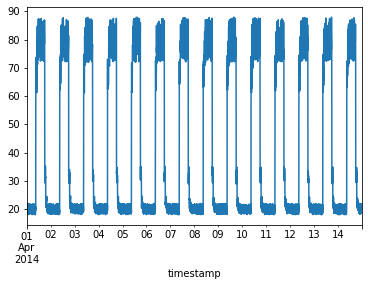

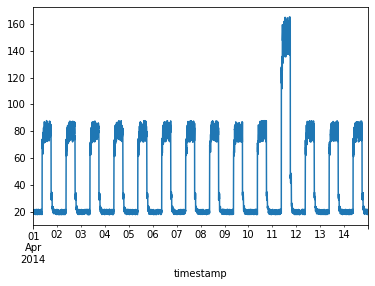

In [7]:
##Para visualizar los timeseries sin anomalias

figure, axis = plt.subplots()
df_small_noise.plot(legend=False, ax=axis)
plt.show()

## Y para el dataset con anomalias

figure, axis = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=axis)
plt.show()

In [21]:

## Los datos se obtienen se han obtenido cada 5 minutos durante 14 dias, es decir: 288 al dia y 4032 en total.

training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Training dataset len: ", len(df_training_value))



Training dataset len:  4032


In [22]:
## Crear secuencias combinando conjuntos de 288 valores del dataset

TIME_STEPS = 288

def create_seq(values, time_steps=TIME_STEPS):
    output=[]
    for i in range(len(values) - time_steps):
        output.append(values[i: (i + time_steps)])
    return np.stack(output)

x_train = create_seq(df_training_value.values)
print("Training shape: ", x_train.shape)


Training shape:  (3744, 288, 1)


In [23]:
## Modelo de autoencoder que recibe el tamano del batch, la longitud de la secuencia y el num_features

model = keras.Sequential([
    layers.Input(shape=(x_train.shape[1],x_train.shape[2])),
    layers.Conv1D( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1D( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose( 16, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Dropout(rate=0.2),
    layers.Conv1DTranspose( 32, 7, padding="same", strides = 2, activation = "relu" ),
    layers.Conv1DTranspose(1, 7, padding="same"),
])
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = "mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 144, 32)           256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 144, 32)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose_12 (Conv1DT (None, 144, 16)           1808      
_________________________________________________________________
dropout_9 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_13 (Conv1DT (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_14 (Conv1DT (None, 288, 1)           

In [27]:
## Como se trata de un modelo de reconstruccion utilizaremos tanto como input e output el dataset de entreno
##Callbacks: https://keras.io/api/callbacks/early_stopping/



history = model.fit(
    x_train,
    x_train,
    epochs = 50,
    batch_size = 128,
    validation_split = 0.1,
    callbacks = [ 
        keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 5, mode="min")
    ]
)

Epoch 1/50
27/27 [==============================] - 1s 48ms/step - loss: 0.0212 - val_loss: 0.0218
Epoch 2/50
27/27 [==============================] - 1s 46ms/step - loss: 0.0204 - val_loss: 0.0220
Epoch 3/50
27/27 [==============================] - 1s 45ms/step - loss: 0.0198 - val_loss: 0.0229
Epoch 4/50
27/27 [==============================] - 1s 52ms/step - loss: 0.0191 - val_loss: 0.0211
Epoch 5/50
27/27 [==============================] - 2s 61ms/step - loss: 0.0185 - val_loss: 0.0215
Epoch 6/50
27/27 [==============================] - 2s 56ms/step - loss: 0.0178 - val_loss: 0.0205
Epoch 7/50
27/27 [==============================] - 2s 61ms/step - loss: 0.0172 - val_loss: 0.0198
Epoch 8/50
27/27 [==============================] - 2s 60ms/step - loss: 0.0167 - val_loss: 0.0194
Epoch 9/50
27/27 [==============================] - 2s 61ms/step - loss: 0.0162 - val_loss: 0.0183
Epoch 10/50
27/27 [==============================] - 2s 67ms/step - loss: 0.0156 - val_loss: 0.0180
Epoch 11/

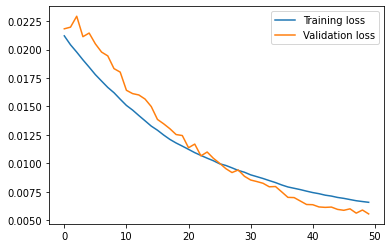

In [28]:
##Nos ponemos a ver como ha ido la perdida de entreno y validacion en el entreno

plt.plot(history.history["loss"], label="Training loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

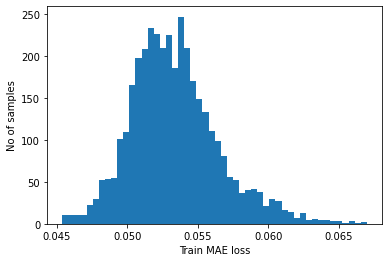

Limite de error de reconstruccion:  0.06699191005457297


In [29]:
## Para ver como poder detectar anomalias nos basariamos en la habilidad de nuestro modelo de reconstruir los datos del input
## Primero tendriamos que identificar el error absoluto medio de nuestras muestras de entreno.Luego encontrar el valor maximo del error absoluto medio,es decir,cuando se ha comportando peor nuestro modelo para reconstruir(threshold)
##En caso de que haya un valor de reconstruccion mayor que el threshold podemos inferir que es un pattern extrano y por lo tanto lo pondriamos como anomalia.

x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis = 1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

threshold = np.max(train_mae_loss)
print("Limite de error de reconstruccion: ", threshold)



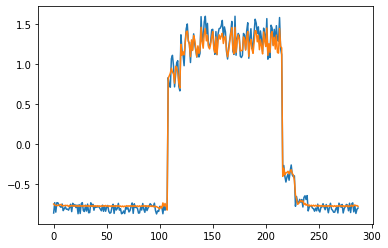

In [31]:
##Vamos a comparar y ver como nuestro modelo ha reconstruido la primera prueba del dia 1 del dataset

plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

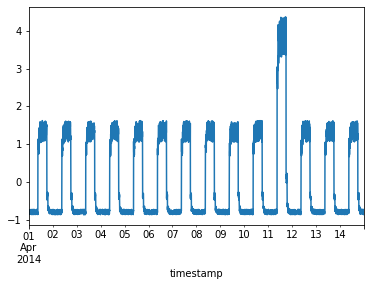

Test input shape:  (3744, 288, 1)


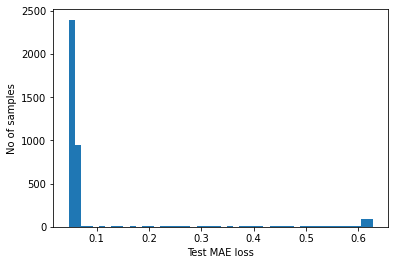

Number of anomalies:  415
Indices of the anomalies:  (array([ 217,  218,  792,  793,  794,  795,  796,  974, 1654, 1656, 1657,
       1658, 1945, 2125, 2520, 2521, 2522, 2698, 2701, 2702, 2703, 2704,
       2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713, 2714, 2715,
       2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724, 2725, 2726,
       2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735, 2736, 2737,
       2738, 2739, 2740, 2741, 2742, 2743, 2744, 2745, 2746, 2747, 2748,
       2749, 2750, 2751, 2752, 2753, 2754, 2755, 2756, 2757, 2758, 2759,
       2760, 2761, 2762, 2763, 2764, 2765, 2766, 2767, 2768, 2769, 2770,
       2771, 2772, 2773, 2774, 2775, 2776, 2777, 2778, 2779, 2780, 2781,
       2782, 2783, 2784, 2785, 2786, 2787, 2788, 2789, 2790, 2791, 2792,
       2793, 2794, 2795, 2796, 2797, 2798, 2799, 2800, 2801, 2802, 2803,
       2804, 2805, 2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814,
       2815, 2816, 2817, 2818, 2819, 2820, 2821, 2822, 2823, 2824, 282

In [33]:
## Preparamos los datos de testing 

def normalize_test(values, mean, std):
    values -= mean
    values /= std
    return values

df_test_val = (df_daily_jumpsup - training_mean) / training_std
figure, axis = plt.subplots()
df_test_val.plot(legend=False,ax = axis)
plt.show()

##Creamos las secuencias necesarias para el dataset de testing
x_test = create_seq(df_test_val.values)
print("Test input shape: ", x_test.shape)

x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis = 1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("Test MAE loss")
plt.ylabel("No of samples")
plt.show()

## Para detectar anomalias
anomalies = test_mae_loss > threshold
print("Number of anomalies: ", np.sum(anomalies))
print("Indices of the anomalies: ",np.where(anomalies))


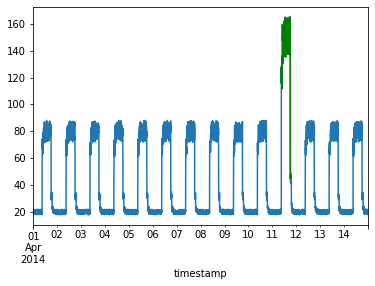

In [41]:
## Ya sabemos los datos que son anomalias por esos queremos obtener los timestamps de esas anomalias.
## i es anomalia si [(i - timestamps + 1) to (i) ] son anomalias
anomaly_ix = []

for data_ix in range(TIME_STEPS - 1, len(df_test_val) - TIME_STEPS + 1):
    if np.all(anomalies[data_ix - TIME_STEPS + 1 : data_ix]):
        anomaly_ix.append(data_ix)

df_subset = df_daily_jumpsup.iloc[anomaly_ix]
figure, axis = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax = axis)
df_subset.plot(legend=False, ax = axis, color="green")
plt.show()